In [1]:
import carla
import glob
import os
import sys
import random
import argparse
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from queue import Queue
from queue import Empty

In [2]:
from camera import *
from lidar import *

In [3]:
# world setting
client = carla.Client('localhost', 2000)
client.set_timeout(2.0)

world = client.get_world()
blueprint_library = world.get_blueprint_library()

traffic_manager = client.get_trafficmanager(8000)
traffic_manager.set_synchronous_mode(True)

original_settings = world.get_settings()
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 3.0
world.apply_settings(settings)

740

In [4]:
# Car
car_bp = world.get_blueprint_library().filter('vehicle.*')[0]
location = random.choice(world.get_map().get_spawn_points())

car = world.spawn_actor(car_bp, location)

In [5]:
# dummy arg
arg = argparse.Namespace()
arg.upper_fov = 15
arg.lower_fov = -25
arg.channels = 64
arg.range = 100
arg.points_per_second = 100000
arg.semantic = False
arg.no_noise = True

arg.camera_width = 1280
arg.camera_height = 1280

In [6]:
# initial sensor bp
lidar_bp = generate_lidar_bp(arg, world, blueprint_library, 10)
camera_bp = generate_camera_bp(arg, world, blueprint_library)

In [7]:
def sensor_callback(sensor_data, sensor_queue, sensor_name):
    # Do stuff with the sensor_data data like save it to disk
    # Then you just need to add to the queue
    
    sensor_queue.put((sensor_data, sensor_name))

sensor_list = []
sensor_queue = Queue()


cam01_transform = carla.Transform(carla.Location(x=0.8, z=1.7))
cam01 = world.spawn_actor(camera_bp, cam01_transform, attach_to=car)
cam01.listen(lambda data: sensor_callback(data, sensor_queue, "camera01"))
sensor_list.append(cam01)

lidar01_transform = carla.Transform(carla.Location(x=0.8, z=1.7))
lidar01 = world.spawn_actor(lidar_bp, lidar01_transform, attach_to=car)
lidar01.listen(lambda data: sensor_callback(data, sensor_queue, "lidar01"))
sensor_list.append(lidar01)

In [8]:
world.tick()
w_frame = world.get_snapshot().frame
print("\nWorld's frame: %d" % w_frame)


World's frame: 770


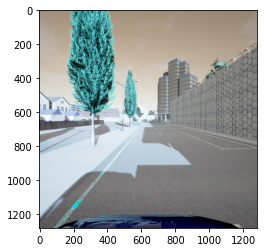

In [9]:
while not sensor_queue.empty():
    s_frame = sensor_queue.get(True, 1.0)
    if s_frame[1] == "lidar01":
        points = process_lidar_data(s_frame[0].raw_data) # (num_pts, 3)
    
    if s_frame[1] == "camera01":
        pic = process_camera_data(s_frame[0].raw_data, arg.camera_width, arg.camera_height)
        
plt.imshow(pic)

In [10]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

from pyntcloud import PyntCloud
import mayavi.mlab as mlab

In [11]:
points.shape

(34226, 3)

In [12]:
def paint_points(points, color=[100,0,0]):
    # just add color
    # color = [r, g, b]
    color = np.array([color])
    new_pts = np.zeros([points.shape[0],6])
    new_pts[:,:3] = points
    new_pts[:, 3:] = new_pts[:, 3:] + color
    return new_pts

points_df = pd.DataFrame(paint_points(points), columns=['x','y','z','red','green','blue'])
cloud = PyntCloud(points_df)

In [18]:
cloud.plot(initial_point_size=0.02)
# cloud.plot(initial_point_size=0.02, backend="threejs")


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
%matplotlib ipympl
# %matplotlib notebook